In [49]:
import numpy as np
from scipy.stats import norm
import torch
from torch import nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from glob import glob

## FakeData

In [56]:
pattern = "fakedata/Data_*.txt*"

data_files = glob(pattern)

#random.shuffle(data_files)

tot_max = len(data_files)
boot_max = tot_max

Ntotdata = len(np.loadtxt(data_files[0], unpack=True))
# df = pd.read_csv(data_files[0], header=None, names=['Value'])
time_max = 100
num_samples = 10000

input = np.ndarray(shape = (tot_max, time_max))
output = np.ndarray(shape = (tot_max, num_samples))

#for ind,file in enumerate(data_files):
for ind in range(0,tot_max):
    #x_temp = np.loadtxt(file, unpack=True)
    x_temp = np.loadtxt(data_files[ind], unpack=True)
    input[ind] = x_temp[0:time_max]
    output[ind] = x_temp[Ntotdata-num_samples:]

print(len(output[boot_max-1]), boot_max)    
    
num_train = boot_max - 1
num_test = boot_max - 1 # boot_max - 1

input_train = input[0:num_train,:]
input_test = input[num_test,:]


out_train = output[0:num_train,:]
out_test = output[num_test,:]

10000 2004


## Harmonic oscillator

In [57]:
boot, time, corr = np.loadtxt("bootstrap/bootstrap1k_primofile.dat", unpack=True)

time_max = int(np.max(time) + 1)
boot_max = int(np.max(boot))

num_train = boot_max - 1
num_test = int(boot_max/2) #boot_max-1 #boot_max - num_train

input = np.ndarray(shape = (boot_max, time_max))
for ind, elem in enumerate(input):
    auxind = ind * time_max
    input[ind] = np.array([corr[ii + auxind] for ii in range(0,time_max)])

#input_train = input[0:num_train,:]
input_test = input[num_test,:]
    
num_samples = 10000
x = np.linspace(0, 0.3, num_samples)
etaharm = 0.05
smear_sigma = 0.01

pdf = norm.pdf(x, loc = etaharm, scale = smear_sigma)
##plt.plot(x, pdf)
##plt.show()

#out_train = np.ndarray(shape = (num_train, num_samples))
#for ii in range(0, num_train):
#    out_train[ii] = 1./2./np.sqrt(np.pi*smear_sigma)*pdf

## Neural Network

#### Parameters

In [58]:
hid_size = 64
hid_size2 = 128
learning_rate = 0.01

#### Net

In [59]:
class netNeur(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(len(input_train[0,:]), hid_size)
        self.activation1=nn.ReLU()
        self.layer2=nn.Linear(hid_size,hid_size2)
        self.activation2=nn.Tanh()
        self.layer3=nn.Linear(hid_size2,len(out_train[0,:]))
        #self.activation3=torch.norm()

    def forward(self, x):
        #print(x.dtype)
        #print(self.layer1.weight.dtype)
        x = x.to(self.layer1.weight.dtype)
        x=self.layer1(x)
        x=self.activation1(x)
        x=self.layer2(x)
        x=self.activation2(x)
        x=self.layer3(x)
        #x=self.activation3(x)
        return x

loss_fun=nn.MSELoss()


rete=netNeur()

losses = []
n_discr = int(num_train/1)
dstep = int((num_train-1)/n_discr + 1)

optimizer = torch.optim.Adam(rete.parameters(), lr=learning_rate)


for j in range(1):
    for i in range(0,n_discr):
        #optimizer = torch.optim.Adam(rete.parameters(), lr=0.01)
        in_train = torch.tensor(input_train[i*dstep:(i+1)*dstep,:])
        #in_train = in_train.float()
        #input_train = input_train.reshape((dstep, len(phi_train[0,:])))
        #print(input_train)
        #p = torch.randn((100,2))*10
        target = torch.tensor(out_train[i*dstep:(i+1)*dstep,:])
        target = target.float()
        #target = torch.tensor([2.0])
        result=rete.forward(in_train)
        #print(target.dtype)
        #print(result.dtype)
        target = target.unsqueeze(1)
        #print(target, result)
        loss=loss_fun(target, result)
        losses.append(loss.item())
        optimizer.zero_grad()
        #for name, param in rete.named_parameters():
        #    print(f"Parameter name: {name}")
        #    print(f"Parameter value: {param}")
        #    print("-------------")
        loss.backward()
        optimizer.step()
        #for name, param in rete.named_parameters():
        #    print(f"Parameter name: {name}")
        #    print(f"Parameter value: {param}")
        #    print("-------------")
        #sys.exit()
        #print(loss)
        #for p in rete.parameters():
        #    p.data.sub_(0.001*p.grad)

        #rete.zero_grad()

In [60]:
print(len(input_train[0,:]), len(input_test))

n_discr = num_test
dstep = int((num_test-1)/n_discr + 1)
in_test = torch.tensor(input_test)

rete.eval()

with torch.no_grad():
    out_net = rete(in_test)


#out_net = distribNTKgp(input_test, input_train, out_train, eta, n_layer, sigma_w, sigma_b, n0)

100 100


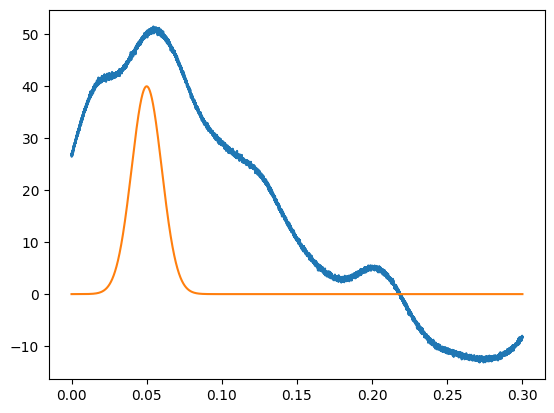

In [61]:
#print(out_net, len(input_test))
plt.plot(x, out_net)
#plt.xlim([0,10])
plt.plot(x, pdf)#out_test)
plt.show()